In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.optimize
import urllib
from typing import Tuple

# Part 1 - Principal Component Analysis [35%]

## Part 1.1 - Implement PCA [15%]

### Restrictions

The use of `sklearn.decomposition.PCA` or `np.cov` is prohibited. You cannot use for loops!! Make sure your operations are vectorized.

In [2]:
def pca(X: np.ndarray, K: int) -> Tuple[np.ndarray, np.ndarray,  np.ndarray]:
    """
    X is an N*D matrix of data (N points in D dimensions)
    K is the desired maximum target dimensionality (K <= min{N,D})

    should return a tuple (P, Z, evals)
    
    where P is the projected data (N*K) where
    the first dimension is the higest variance,
    the second dimension is the second higest variance, etc.

    Z is the projection matrix (D*K) that projects the data into
    the low dimensional space (i.e., P = X * Z).

    and evals, a K dimensional array of eigenvalues (sorted)
    """
    
    N, D = X.shape

    # make sure we don't look for too many eigs!
    if K > N:
        K = N
    if K > D:
        K = D

    ### TODO: YOUR CODE HERE
    col_mean=X.mean(0)
    centered_data=X-col_mean
    #forming the covarience matrix
    covariance_matrix=(np.dot(centered_data.T, centered_data))/(N-1)
    #finding the eigen values and eigen vectors
    eig_val,eig_vec= np.linalg.eig(covariance_matrix)
    #sorting the eigen values and eigen vectors
    idx = eig_val.argsort()[::-1]
    eig_val = eig_val[idx]
    eig_vec = eig_vec[:,idx]
    
    P=np.dot(centered_data,eig_vec)
    P=P.real
    Z=eig_vec.real    
    evals=eig_val.real
    return (P, Z, evals)

Our first test of PCA will be on Gaussian data with a known covariance matrix. First, let's generate some data and see how it looks.

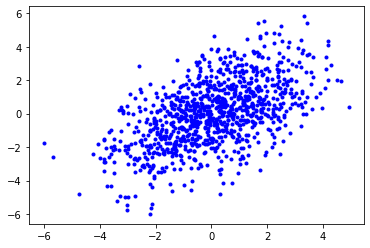

In [3]:
M = np.array([[3,2],[2,4]])
(U,S,VT) = np.linalg.svd(M)
D = np.diag(np.sqrt(S))

Si = U @ D @ VT
x = np.random.randn(1000,2) @ Si
plt.plot(x[:,0], x[:,1], 'b.');

We can also see what the sample covariance is!

In [4]:
np.cov(x.T)

array([[3.04231828, 1.86071523],
       [1.86071523, 3.75031863]])

Note that the sample covariance of the data is almost exactly the true covariance of the data. If you run this with 100,000 data points (instead of 1,000), you should get something even closer to 
$\begin{bmatrix} 3 & 2 \\ 2 & 4 \end{bmatrix}$.

Now, let's run PCA on this data. We basically know what should happen, but let's make sure it happens anyway (still, given the random nature, the numbers won't be exactly the same). We can project the data onto the first eigenvalue and plot it in red, and the second eigenvalue in green. 

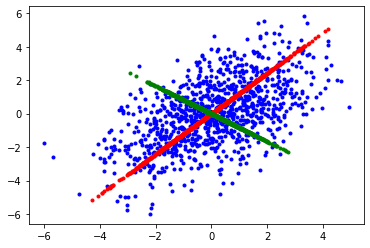

In [5]:
(P, Z, evals) = pca(x, 2)

x0 = (x @ Z[:,0,None]) * Z[:,0,None].T
x1 = (x @ Z[:,1,None]) * Z[:,1,None].T

plt.plot(x[:,0], x[:,1], 'b.', x0[:,0], x0[:,1], 'r.', x1[:,0], x1[:,1], 'g.');

## Part 1.2 - Visualization of MNIST [5%]

Lets work with some [handwritten digits](https://en.wikipedia.org/wiki/MNIST_database). Before we try PCA on them, let's visualize the digits. Specifically, implement the function `draw_digits`.

It must implement the following specifications:
1. Visualize `K` random samples from `X`, with no repeats.
2. Digits must be visualized on 5 column subplots.
3. A gray colormap must be used to visualize the digits.
4. Add the label of the digit as white text on the upper left corner of the subplot, with font size 16.
5. Remove the axes on the subplot.

In [6]:
np.random.seed(0)

def draw_digits(X: np.ndarray, Y: np.ndarray, K: int = 20):
    ### TODO: YOUR CODE HERE
    P=np.random.choice(X.shape[0], K,replace=False)
    P = np.array(P)
    nrows=K//5
    ncols=5
    h, w = 10, 10   
    figsize = [10, 10]     
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=figsize)
    for i, ax in enumerate(ax.flat):
        img = X[P[i]].reshape(28,28)
        ax.imshow(img,cmap='gray')
        ax.text(5, 5, Y[P[i]],
            verticalalignment='bottom', horizontalalignment='right',
            color='white', fontsize=16)
        ax.axis('off')
    plt.show()

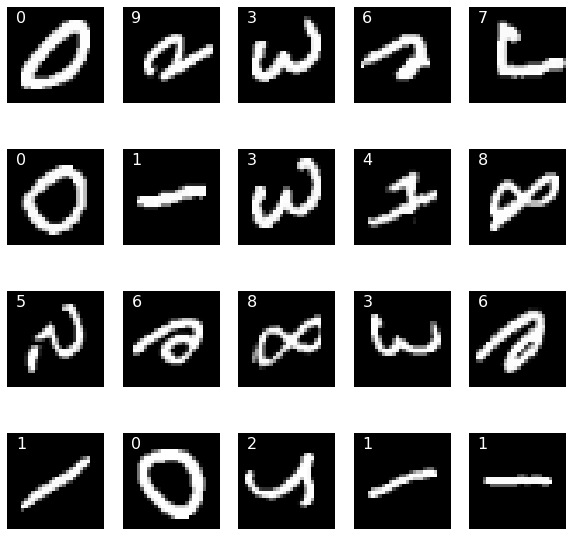

In [7]:
def load_digits():
    X = np.zeros((1000, 784), dtype=float)
    Y = np.zeros((1000,), dtype=int)

    with open('data/digits') as f:
        for idx, line in enumerate(f):
            vals = [int(v) for v in line.split()]
            Y[idx] = vals[0] % 10
            for i in range(len(vals)//2-1):
                X[idx, vals[i*2+1]] = float(vals[i*2+2])
            X[idx,:] = X[idx,:] / np.linalg.norm(X[idx,:])

    return X, Y

X, Y = load_digits()
draw_digits(X, Y)

## 1.3 - Plotting Explained Variance [10%]

Let's examine all the principal components of the digits data.

Plot the explained variance of the principal components, with x-axis being the number of principal components, and the y-axis being the percent variance explained. How many eigenvectors do you have to include before you've accounted for 90% of the variance?
95%? Label these points on your plot.

principle component at which percent variance is 90%
81
principle component at which percent variance is 95%
135


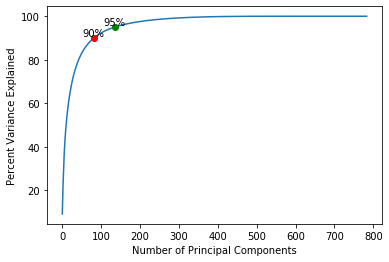

In [28]:
(P, Z, evals) = pca(X, 784)
total_sum=np.sum(evals)
percent_variance=evals/total_sum*100
percent_variance_cum=np.cumsum(percent_variance)

index_x_90=(np.where(percent_variance_cum <90))[0].shape[0]
print("principle component at which percent variance is 90%")
print(index_x_90)
value_y_90=percent_variance_cum[index_x_90]
plt.plot(percent_variance_cum)
plt.plot(index_x_90,value_y_90,'or')
plt.text(index_x_90,value_y_90,'90%',horizontalalignment='center',
        verticalalignment='bottom')
index_x_95=(np.where(percent_variance_cum <95))[0].shape[0]
value_y_95=percent_variance_cum[index_x_95]
print("principle component at which percent variance is 95%")
print(index_x_95)
plt.plot(index_x_95,value_y_95,'og')
plt.text(index_x_95,value_y_95,'95%',horizontalalignment='center',
        verticalalignment='bottom')
plt.xlabel('Number of Principal Components')
plt.ylabel('Percent Variance Explained')
plt.show()

Eventually, the eigenvalues drop to zero (note that some may be negative due to floating point errors).

**ANSWER**:We will require 80 eigenvectors before we accounted for 90% of the variance ie at 81th eigenvector the variance becomes 90\%<br>
We will require 134 eigenvectors before we accounted for 95% of the variance ie at 135th eigenvector the variance becomes 95\%

## Part 1.4 - Visualization of Dimensionality Reduction [5%]

Now, let's plot the top 50 eigenvectors:

In [ ]:
draw_digits(Z.T[:50,:], np.arange(50))

Do these look like digits? Should they? Why or why not?

**ANSWER:** No, they donot look like the digits.They should not look like the digits in the MNIST dataset.
They are eigenimages. These eigenimages represent the direction of maximum variation among the set of images(MNIST dataset).
Therefore, the coordinates of an image along these eigenvector directions give helful set of parameters, for characterizing the image.

# Part 2 - Softmax Regression [45%]

The goal of this part of the project is to implement Softmax Regression in order to classify the MNIST digit dataset. Softmax Regression is essentially a two-layer neural network where the output layer applies the Softmax cost function, a multiclass generalization of the logistic cost function.

In logistic regression, we have a hypothesis function of the form

$$\mathbb{P}[y=1] = \frac{1}{1 + e^{-wx}}$$

where $\mathbf{w}$ is our weight vector. Like the hyperbolic tangent function, the logistic function is also a sigmoid function with the characteristic 's'-like shape, though it has a range of $(0, 1)$ instead of $(-1, 1)$. Note that this is technically not a classifier since it returns probabilities instead of a predicted class, but it's easy to turn it into a classifier by simply choosing the class with the highest probability.

Since logistic regression is used for binary classification, it is easy to see that:

$$\begin{aligned}
\mathbb{P}[y=1] &= \frac{1}{1 + e^{-wx}} \\
&= \frac{e^{wx}}{e^{wx} + e^{0 \cdot x}} \\
\end{aligned}$$

Similarily,

$$\begin{aligned}
\mathbb{P}[y=0] &= 1 - \mathbb{P}[y=1] \\
&= 1 - \frac{e^{wx}}{1 + e^{wx}} \\
&= \frac{e^{0 \cdot x}}{e^{wx} + e^{0 \cdot x}} \\
\end{aligned}$$

From this form it appears that we can assign the vector $w_1 = w$ as the weight vector for class $1$ and $w_0 = \vec{0}$ as the weight vector for class $0$. This motivates generalization to classification with more than 2 classes. By assigning a separate weight vector $w_i$ to each class, for each example $x$ we can predict the probability that it is class $i$, and again we can classify by choosing the most probable class.

$$\mathbb{P}[y=i] = \frac{e^{w_i x}}{\sum\limits_j e^{w_j x}}$$

A more compact way of representing the values $w_i x$ is $Wx$ where each row $i$ of $W$ is $w_i$. We can also represent a dataset $\{x_i\}$ with a matrix $X$ where each column is a single example, resulting in $WX$.

## Part 2.1 - Questions [5%]

For both problems, assume there are $C$ classes, $n$ be the number of samples, and $d$ be the number of features for each sample. 

1. Prove that the probabilities outputed by the softmax function sum to 1. 

**ANSWER**:<br>Given:<br>
<ol>
<li>There are $C$ classes.</li>
<li>There are $n$ samples.</li>
<li>Each sample has $d$ features.</li>
</ol>  
We select a sample form the data set $X$ be $x$
The probability that the sample $x$ selected belongs to class-1 can be given as $$\mathbb{P_1} = \frac{e^{w_1 x}}{\sum\limits_C e^{w_c x}}$$.<br>
The probability that the sample $x$ selected belongs to class-2 can be given as $$\mathbb{P_2} = \frac{e^{w_2 x}}{\sum\limits_C e^{w_c x}}$$.And similarly, we can wirte the probability that the sample $x$ selected belongs to class-C as $$\mathbb{P_C} = \frac{e^{w_C x}}{\sum\limits_C e^{w_c x}}$$.<br>
Now summing all the above probabilities we have:<br>
$P_{total}$=$P_1$+$P_2$+$P_3$+.....$P_C$ <br>
$$P_{total}=\frac{e^{w_1 x}+e^{w_2 x}+e^{w_3 x}....e^{w_C x}}{\sum\limits_C e^{w_c x}}$$
We observe that the numerator is nothing but:$$\sum\limits_C e^{w_c x}$$. 
Thus,$P_{total}=\frac{\sum\limits_C e^{w_c x}}{\sum\limits_C e^{w_c x}}$=1


2. Given the description of matrices $W$, $X$ above, what are the dimensions of $W$, $X$, and $WX$? 

**ANSWER**:Let the number of Classes be $C$ and number of samples be $n$ with $d$ dimensions.The dimension of $W$ is (C,d) $X$ is (d,n) and $WX$ is (C,n)

## Part 2.2 - Implementing a Softmax Classifier [20%]
We can also train on this model with an appropriate loss function. The Softmax loss function is given by

$$\xi(W) = -\sum\limits_{i=1}^{n}\sum\limits_{j=1}^{C}\delta_{y_i,j}\log \mathbb{P}(y_i = j)$$

where $n$ is the number of samples, $C$ is the number of classes, $\delta_{y_i,j}$ is the [kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta), $y_i$ is the label of sample $i$, and $\mathbb{P}(y_i = j)$ is calculated using a softmax function using the weights from matrix $W$.

Note that 

$$\delta_{y_i,j} = \begin{cases}1 &\text{if } y_i = j \\ 0 & \text{if } y_i \neq j\end{cases}$$

The gradient of this function is given by 

$$\nabla_{\vec{w_j}} \xi(W) = \sum_{i=1}^{n}{ \left[ x_i \left( \mathbb{P}[y_i = j] - \delta_{y_i, j} \right) \right]}$$

The derivation for this can be found in the references. Note that the kronecker delta and the probabilities can be represented as matrices, which makes the code for the loss and the gradient very simple.

You cannot use for loops!! Make sure your operations are vectorized.

In [ ]:
class SoftmaxRegression:
    """
    Here you will fill in this incomplete implementation of Softmax regression.

    Adapted from code by Jatin Shah
    """
    def __init__(self, num_classes, ex_size, opts={'maxIter':400}):
        """
        num_classes:    number of possible classifications
        ex_size:        size of attribute array (number of input features)
        reg:            regularizing term coefficient (lambda)
        opts:           in this class the only option used is maxIter
        """

        self.num_classes = num_classes
        self.ex_size = ex_size
        self.opts = opts

        # Initialize weight matrix with empty matrix
        self.W = np.zeros((num_classes, ex_size))


    def cost(self, X, Y, W=None):
        """
        Calculate the cost function for X and Y using current weight matrix W. Note that we are not using
        a regularizer in the cost; this is equivalent to lambda = 0.

        X:              (M x N) matrix of input feature values,
                            where M = ex_size, N = number of examples
        Y:              (N x 1) array of expected output classes for each example

        Returns the cost and its gradient, which is the form needed to use scipy.optimize.minimize
        """

        if W is None:
            W = this.W
        num_classes = self.num_classes
        ex_size = self.ex_size

        W = W.reshape(num_classes, ex_size)         # Ensure W is in the correct dimensions
        N = X.shape[1]                              # N = number of examples

        W_X = W.dot(X)                              # This is our activation matrix with dimensions (A * B)
                                                    # where A is the number of classes and B is the number
                                                    # of examples. (W_X[a, b] gives the activation of example
                                                    # b for class a.) You will use this matrix to find the
                                                    # probabilities that example b is class a using the
                                                    # softmax formula.

        W_X = W_X - np.amax(W_X)

        # This is the indicator function used in the loss function, where indicator[a, b] = 1
        # when example b is labeled a (according to the target Y) and indicator[a, b] = 0 otherwise.

        indicator = scipy.sparse.csr_matrix((np.ones(N), (Y, np.array(range(N)))))
        indicator = np.resize(np.array(indicator.todense()), (num_classes, N))


        # Each row of W_X is the set of activations for each class corresponding to
        # one example; the probabilties are given by the exponential of each entry
        # divided by the sum of the exponentials over the entire column.

        # The cost associated with a single example is given by -1 times the log probability
        # of the true class; initialize the cost variable to the AVERAGE cost over all the examples.
        # Hint: there's an easy way to do this with the indicator matrix.

        # The gradient has the same dimensions as W, and each component (i,j) represents the
        # derivative of the cost with respect to the weight associated with class i, attribute j.
        # The gradient associated with a single example x is given by A * x_T, where x_T is
        # the transpose of the example, and A is a vector with component i given by (P(class = i) - 1)
        # if the true class is i, and (P(class = i)) otherwise. Notice that this multiplication gives
        # the desired dimensions. Find the AVERAGE gradient over all the examples. Again, there is
        # an easy way to do this with the indicator matrix.

        # TODO: Compute the predicted probabilities, the total cost, and the gradient.

        ### YOUR CODE HERE ###
        e_x = np.exp(W_X) 
        probabilities =e_x / e_x.sum(axis=0)
        cost =(-np.sum(np.log(probabilities)*indicator))/N
        gradient = (np.dot((-indicator+probabilities),np.transpose(X))/N)
        ### YOUR CODE (ENDS) HERE ###

        # flatten is needed by scipy.optimize.minimize
        return cost, gradient.flatten()


    def train(self, X, Y):
        """
        Train to find optimal weight matrix W. Here we make use of the SciPy optimization library but
        in theory you could implement gradient descent to do this as well.

        X:              (M x N) matrix of input feature values,
                            where M = ex_size, N = number of examples
        Y:              (N x 1) array of expected output classes for each example
        maxIter:        Maximum training iterations
        """

        num_classes = self.num_classes
        ex_size = self.ex_size
        W = self.W

        # Set maxIter hyperparameter
        if self.opts['maxIter'] is None:
            self.opts['maxIter'] = 400

        # Lambda function needed by scipy.optimize.minimize
        J = lambda w: self.cost(X, Y, w)

        result = scipy.optimize.minimize(J, W, method='L-BFGS-B', jac=True, options={'maxiter': self.opts['maxIter'], 'disp': True})
        self.W = result.x # save the optimal solution found

    def predict(self, X):
        """
        Use W to predict the classes of each example in X.

        X:              (M x N) matrix of input feature values,
                            where M = ex_size, N = number of examples

        """

        W = self.W.reshape(self.num_classes, self.ex_size)
        W_X = W.dot(X)

        # TODO: Compute the predicted probabilities and the predicted classes for each example
        # Reminder: The predicted class for a single example is just the one with the highest probability

        ### YOUR CODE HERE ###
        e_x = np.exp(W_X) 
        probabilities=e_x / e_x.sum(axis=0)
        predicted_classes =probabilities.argmax(axis=0)

        ### YOUR CODE (ENDS) HERE ###

        return predicted_classes

You can test your implementation of `SoftmaxRegression` by running the following snippet below:

In [ ]:
def good_job(path):
    a = plt.imread(urllib.request.urlopen(path))
    fig = plt.imshow(a)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

def loadMNIST(image_file, label_file):
    """
    returns a 28x28x[number of MNIST images] matrix containing
    the raw MNIST images
    :param filename: input data file
    """

    with open(image_file, "r") as f:
        magic = np.fromfile(f, dtype=np.dtype('>i4'), count=1)

        num_images = np.fromfile(f, dtype=np.dtype('>i4'), count=1)[0]
        num_rows = np.fromfile(f, dtype=np.dtype('>i4'), count=1)[0]
        num_cols = np.fromfile(f, dtype=np.dtype('>i4'), count=1)[0]

        exSize = num_rows * num_cols
        images = np.fromfile(f, dtype=np.ubyte)
        images = images.reshape((num_images, exSize)).transpose()
        images = images.astype(np.float64) / 255

    with open(label_file, 'r') as f:
        magic = np.fromfile(f, dtype=np.dtype('>i4'), count=1)
        num_labels = np.fromfile(f, dtype=np.dtype('>i4'), count=1)
        labels = np.fromfile(f, dtype=np.ubyte)

    return images, labels

ex_size = 28*28   # size of MNIST digits
num_classes = 10  # 10 digits to classify

X, Y = loadMNIST('data/train-images.idx3-ubyte', 'data/train-labels.idx1-ubyte')
testX, testY = loadMNIST('data/t10k-images.idx3-ubyte', 'data/t10k-labels.idx1-ubyte')

In [ ]:
sm = SoftmaxRegression(num_classes, ex_size)
sm.train(X, Y)

predictions = sm.predict(testX)
assert predictions.shape == testY.shape, "predictions and testY must have the same shape!"
accuracy = 100 * np.sum(predictions == testY, dtype=np.float64) / testY.shape[0]
print(f"Accuracy: {accuracy:.2f}")
assert accuracy >= 92, "Your implementation is sadly incorrect :("

print("TEST PASSED!!!")
good_job("https://www.cs.umd.edu/~tomg/img/important_memes/hacker_database.png")

## Part 2.3 - Stability [10%]

In the `cost` function of `SoftmaxRegression`, we see the line

```python3
W_X = W_X - np.amax(W_X)
```

1. What is this operation doing?

**ANSWER**: This operation is finding the max value from the matrix W_X and subtracting the max value from each element of W_X. This is called the Exponential-normalize trick and helps in preventing arithmetic computational problem. If any element value of the W_X is very large then the exponential of that large value can be tremendous huge, which makes the denominator sum very large, and dividing by a huge number can cause arithmetic computation problems.Thus by doing the above step we overcome this computation problems by making the input value to exp() limiting to negative values or 0.

2. Show that this does not affect the predicted probabilities.

**ANSWER**:The above trick does not affect the prediction probability. It can be explanied by the following example:<br>
$$W=\begin{bmatrix} 10 & 12 & 14 \\ 0 & 1 & 2 \\ 11 & 2 & 4 \end{bmatrix}$$
$$X=\begin{bmatrix} 1 & 2 & 3 \\ 2 & 3 & 4 \\ 5 & 4 & 6 \end{bmatrix}$$
The code below shows both results.

**WITHOUT EXPONENTIAL-NORMALIZATION TRICK**

In [ ]:
import numpy as np
A = np.array([[10,12,14],[0,1,2],[11,2,4]]) 
print(A)
B=np.array([[1,2,3],[2,3,4],[5,4,6]])
print(B)  
A_B = A.dot(B) 
print(A_B)
e_x = np.exp(A_B) 
probabilities=e_x / e_x.sum(axis=0)
print(probabilities)
print(probabilities.sum(axis=0))

 **WITH EXPONENTIAL-NORMALIZATION TRICK**

In [ ]:
import numpy as np
A = np.array([[10,12,14],[0,1,2],[11,2,4]]) 
print(A)
B=np.array([[1,2,3],[2,3,4],[5,4,6]])
print(B)  
A_B = A.dot(B) 
print(A_B)
A_B = A_B - np.amax(A_B)
print(A_B)
e_x = np.exp(A_B) 
probabilities=e_x / e_x.sum(axis=0)
print(probabilities)
print(probabilities.sum(axis=0))

3. Why might this be an optimization? Justify your answer.

**ANSWER**:This is called the Exponential-normalize trick. It might be considered as a optimization as it helps in preventing arithmetic computational problem. If any element value of the W_X is very large then the exponential of that large value can be tremendous huge, which makes the denominator sum very large, and dividing by a huge number can cause arithmetic computation problems.Thus by doing the above step we overcome this computation problems by making the input value to exp() limiting to negative values or 0.

## 2.4 - Analysis of Classifier Accuracy [10%]

Plot the accuracy of the classifier as a function of the number of examples seen.
Do you observe any overfitting or underfitting? Discuss and expain what you observe. Use the helper functions provided below.

In [ ]:
def train_test(classifier, X, Y, Xtest, Ytest):
    """
    Train a classifier on data (X,Y) and evaluate on
    data (Xtest,Ytest).  Return a tuple of:
      * Training data accuracy
      * Test data accuracy
    """
    classifier.train(X, Y)
    train_acc = np.mean(Y == classifier.predict(X))
    test_acc = np.mean(Ytest == classifier.predict(Xtest))

    print(f"Training accuracy {train_acc}, test accuracy {test_acc}")

    return train_acc, test_acc

def learning_curve(classifier, X, Y, Xtest, Ytest):
    """
    Generate a learning curve by repeatedly halving the amount of
    training data until none is left.

    We return a triple containing:
      * The sizes of data sets we trained on
      * The training accuracies at each level
      * The test accuracies at each level
    """

    N = X.shape[1]                   # how many total points?
    M = int(np.ceil(np.log2(N)))     # how many classifiers will we have to train?

    data_sizes = np.zeros(M)
    train_accs  = np.zeros(M)
    test_accs   = np.zeros(M)

    for i in range(1, M+1):
        # select every 2^(M-i)th point
        ids = np.arange(0, N, 2**(M-i))
        Xtr = X[:, ids]
        Ytr = Y[ids]

        # report what we're doing
        print(f"Training classifier on {ids.size} points...")

        # train the classifier
        train_acc, test_acc = train_test(classifier, Xtr, Ytr, Xtest, Ytest)

        # store the results
        data_sizes[i-1] = ids.size
        train_accs[i-1] = train_acc
        test_accs[i-1]  = test_acc
        
        
    return (data_sizes, train_accs, test_accs)

In [ ]:
print(X.shape,Y.shape)

data_sizes, train_accs, test_accs = learning_curve(sm, X, Y, testX, testY)

fig, axs = plt.subplots(1, 2)
axs[0].plot(data_sizes,train_accs)
axs[0].set_title('model accuracy trainning')
axs[0].legend(['train'], loc='upper right')
axs[0].set_xlabel('accuracy')
axs[0].set_xlabel('data size')
axs[1].plot(data_sizes,test_accs, 'tab:orange')
axs[1].set_title('model accuracy testing')
axs[1].legend(['test'], loc='upper right')
axs[1].set_xlabel('accuracy')
axs[1].set_xlabel('data size')
plt.show()


**ANSWER**:
Considering the traning accuracy was nearly equal to 1.0 for small and medium number of data size. However, for data size greater than 10000 the traning accuracy started reducing and reached minima of 0.93 for 60000 data points. In case of testing accuracy the it was lower than the training accuracy for data lower and medium sized data. A increasing trend was observed as the data size grew and testing accuracy reached its peak at  0.91. Thus initially a overfitting trend is observed but as the data size increases it reduces and testing and training accuracy becomes nearly equal.

# Part 3 - Deep Learning Software [20%]

We'll examine the use of software packages for deep learning, focusing on TensorFlow and PyTorch.

1. [Watch this lecture from Stanford](https://www.youtube.com/watch?v=6SlgtELqOWc).
2. Read the papers on [TensorFlow](http://download.tensorflow.org/paper/whitepaper2015.pdf) and [PyTorch](https://openreview.net/pdf?id=BJJsrmfCZ).

Summarize the lecture and each of the papers. Some points that you may discuss are listed below. Note that this list is not comprehensive.

- What is difference between CPU and GPU?
- What are benefits that these machine learning libraries offer?
- What is the difference between static and dynamic computational graphs?
- How gradient computation is done in these frameworks?
- Which framework would you use and why?

**ANSWER**: The lecture mainly focused on the use of Deep Learning Softwares like TensorFlow and PyTorch. It covered topics listed below:<br>
<ol>
<li>CPU and GPU use in Deep Learning</li>
<li>Deep Learning Framework-TensorFlow \& PyTorch </li>
<li>Advantages of using Deep Learning Software over traditional Programing</li>
</ol>

**CPU and GPU use in Deep Learning** 

In the lecture it was mentioned that the CPUs have less number of cores when compared to GPUs.But each core of CPU is much faster and more capable of performing sequential tasks when compared to GPUs.
It was noticed that GPUs are more favourable for parallel computing like matrix operations on huge data as they give more throughput by spliting operations across different cores.Additionally, the speaker discussed that programming a GPU in CUDA is a difficult task as it involves complex memory management processes and any mistake in allocating and deallocating the resource may lead to failures.
Thus, using predefined libraries and API like CuDNN, and cuFFT is more prefferable.The speaker mentioned about his research on comparision of performance of CPU and different GPU with CuDNN and without CuDNN. He showed that the GPUs performance is about 66 times, 67 times, 71 times, 64 times 76 times, more efficient than CPU for VGG-16, VGG-19, ResNet18, ResNet50 and  ResNet200 respectively.
He also mentioned that the performance increases by 3 times when we shift from unoptimised CUDA to CuDNN provided by NVIDIA. Moreover, training can bottelneck on reading data and transfering to GPU.To overcome this problem the speaker suggested three solutions: 
<ol>
<li>Read all data and store it on RAM</li>
<li>Use SSD instead of HDD</li>
<li>Use multi threaded process for pre-fetching the data</li>
</ol> 
 
 
**Deep Learning Frameworks**

There are many deep learning frame work available but the speaker emphasised on Tensorflow and Pytorch and provided the comparision and similarities of these frameworks with traditional python programs. 
The main need of deep learning frame work are listed below:
<ol>
<li>Building big computational graph is easy</li>
<li>Computation of gradient,forward pass and other nesseary opeartions are quick and easy due to inbuild functions and library</li>
<li>Switching from CPU computation to GPU computation is easy</li>
<li>Many deep learning frame work can exectute operation on different hardware platforms using Distributed Execution Engine </li>
</ol> 
Additionally, the speaker talked about the computation process in TensorFlow. He mentioned that the computation is broken down into two processes  namely  i) defining computation graphs and ii) runing the computational graph.
Building the graph is an important step as it informs the frame work (TensorFlow) about the sequence of operation, and different mathematical computation that needs to executed.No memory allocation is done at the point of creating the graphs. 
For creating graphs we use functions like placeholders, variables, and other matrix operations defined in the tf library. Using tf.Variable and tf.Assign is advantageous in situations where we have to update a particular variable value at each run, because it saves the time required to copy the new data form CPU to GPU at each run by making the variable persist in the graph between calls.
When graph creation is finished we can run the graph with real values. This is done using Session- It is context in which we run a computaion graph.
Futhermore, higher level wrappers and API like Keras, TFLearn and others are available to make the computational models in a realtively easy way. 
PyTorch has three level of abstractions:
<ol>
<li>Tensor-It is a multi-dimensional array that runs on GPUs</li>
<li>Variable-Node in a computational graph which stores data and gradients required for computation </li>
<li>Module- A neural network layer which can be used to build big network;used to store states and weights</li>
</ol>  

 
|Static Graphs|Dynamic Graphs|
|------|------|
|1) Build graph once and use the same graph for each computational run  | 1) Build graph ever time for each computational run  |
|2) Graph can be optimized before being used  |2) Such offline optimization is not possible    |
|3) Can  Serialize the graph to run it without the code to build the graph   |3) Running and graph creation are interdependent and we always need the code that build the graph |
|4) Deployment in different environment is easy as graph is already build before hand   |4) Depolyment is little hard when environment changes   |
 
**Gradient computation-Pytorch**<br>
The example attached at the end of pdf is expalained here!!!!!!.<br>
Let us consider the above mentioned computation using Autograd.
Each tensor has the following attributes associated with it:<br>
"data" attribute holds the tensor data.<br> "grad" holds the grandient value when calculated.<br> "grad_fun" points to a node in the backward graph.<br> "is_leaf" tells wether it is a leaf node <br> "required_grad"= True states the tensors for which gradient needs to be computed.<br> 
We notice that tensor "a" is multiplied with tensor "b" to form tensor "c". Which is indeed multiplied by tensor "d" to produce "e"
In the backend a computational graph is created. when  "mul" function is called it has access to a context variable "ctx" and it is used to stores the values needed for backward pass.
This "ctx" variable will be passed to the "MulBackward" operation in the backward pass.
"MulBackward" has "next_functions" which is a list of tuple and has "MulBackward" for "function that produced c" tensor and "AccumulateGrad" for "d" tensor as it has required_grad=True.
The same procedure is followed up to tensor "a" and "b".
When e.backward() is performed we will have the following assingmnets<br>
d-->"grad"=6<br> a-->"grad"=12<br> b-->"grad"=8<br>
Tensor has an attribute called "version" which is used to keep track of tensors in the in-place operation.


**Gradient computation-TensorFlow**

When Tensorflow wants to find gradient of tensor A with respect to some tensor I, where A depends on I. Tensorflow finds path in computationgraph from I to A. Then it backtracks A to I, such that for each operation in the backward parth it adds a node to the Tensorflow  graph. It finds partial gradient along the backward path using chainrule . Additionally, the newly added node computes the "gradient function" for the operation in the forward path. It must be noted that gradient function can be registered by any operation. The function takes as input partially computed gradients and input/output of the forward operation.


 
**My Choice of Deep Learning-TensorFlow**<br>
I would choose TensorFlow over any deep learning framework because of the following features and advantages:
<ol>
<li>Model buliding in TensorFlow using wrappers like Keras is fast.Adittionaly, debugging is easy and quick.</li>
<li>It provides feature of distributated computation; which enables us to divide big neural network or do training of a large data by dividing it into small blocks on diffrent system.</li>
<li>Visualization provided by Tensorboard helps when working on a new model in research, as we can plot graphs for attributes like accuracy, loss etc and later compare with the plot of other models.</li>
</ol>  


![title](ML_project_2.jpg)